In [2]:
import warnings
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import datetime
from scipy import stats
import os
import platform
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
import xgboost as xgb
from xgboost import plot_importance
import pickle

%matplotlib inline
warnings.filterwarnings("ignore")
pd.set_option('display.max_colwidth',100)

In [2]:
demand_train_A = pd.read_csv('../dataset/demand_train_A.csv')
demand_test_A = pd.read_csv('../dataset/demand_test_A.csv')
geo_topo = pd.read_csv('../dataset/geo_topo.csv')
inventory_info_A = pd.read_csv('../dataset/inventory_info_A.csv')
product_topo = pd.read_csv('../dataset/product_topo.csv')
weight_A = pd.read_csv('../dataset/weight_A.csv')

# 1. 特征工程
- 1.1 日期处理（天数补齐）
- 1.2 处理geography_level、product_level多级别特征
- 1.3 使用qty滑窗添加新特征：last14max、last14min、last14std、last14mean、last14median
- 1.4 过去14天下，在同geography与product的qty 资源使用量。

## 1.1 日期处理 （天数补齐）

In [3]:
first_dt = pd.to_datetime("20180604")  
last_dt = pd.to_datetime("20210301")  # 用来限定使用的是历史数据而不是未来数据
start_dt = pd.to_datetime("20210301")  # 用来划定预测的针对test的起始时间
end_dt = pd.to_datetime("20210607")  # 预测需求的截止时间

demand_train_A["ts"] = demand_train_A["ts"].apply(lambda x: pd.to_datetime(x))
demand_train_A.drop(['Unnamed: 0'],axis=1,inplace=True)

demand_test_A["ts"] = demand_test_A["ts"].apply(lambda x: pd.to_datetime(x))
demand_test_A.drop(['Unnamed: 0'],axis=1,inplace=True)

dataset = pd.concat([demand_train_A, demand_test_A])

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 346768 entries, 0 to 61935
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   unit             346768 non-null  object        
 1   ts               346768 non-null  datetime64[ns]
 2   qty              346768 non-null  float64       
 3   geography_level  346768 non-null  object        
 4   geography        346768 non-null  object        
 5   product_level    346768 non-null  object        
 6   product          346768 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 21.2+ MB


In [5]:
# 删除掉出现 qty中出现负值的样本，这部分样本数值不对
dataset = dataset[~(dataset.qty < 0)]
print(np.isnan(dataset['qty']).any())
print(np.isinf(dataset['qty']).any())

False
False


In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 345316 entries, 0 to 61935
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   unit             345316 non-null  object        
 1   ts               345316 non-null  datetime64[ns]
 2   qty              345316 non-null  float64       
 3   geography_level  345316 non-null  object        
 4   geography        345316 non-null  object        
 5   product_level    345316 non-null  object        
 6   product          345316 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 21.1+ MB


In [7]:
# unit count
dataset.unit.value_counts()

9b8f48bacb1a63612f3a210ccc6286cc    1100
6ed4341ad9d2902873f3d9272f5f4df1    1100
4d3ca213b639541c5ba4cf8a69b1e1ed    1100
06531cd4188630ce2497cd9983aacf5e    1100
326cb18b045e5baefa90bbc2e8d52a32    1100
                                    ... 
7d9cbb373fddba4ce2cddcec96bccbeb     148
8ccf1c02bb050cb3fc4f13789cdfe235     147
e9abc1de6bd24d10ebe608959d0e5bac     141
5dbe225a546a680640eb5f7902b42cdd     141
12f892a6de3f9cf4411fb9db4fdd6691     138
Name: unit, Length: 632, dtype: int64

In [9]:
# 将数据转化后存入 mysql
labels = ['unit', 'ts', 'qty', 'geography', 'product']
data = dataset[labels].copy()

In [11]:
data = pd.merge(data, geo_topo, how='left', left_on = 'geography', right_on = 'geography_level_3')
data = pd.merge(data, product_topo, how='left', left_on = 'product', right_on = 'product_level_2')
data = data.drop(['geography','product'],axis = 1)
data

,unit,ts,qty,geography_level_1,geography_level_2,geography_level_3,product_level_1,product_level_2
0,9b8f48bacb1a63612f3a210ccc6286cc,2018-06-04,11926.828600,c89adbf4129750cd35f3b818167cd7ab,7a399889b9a4aed64afd0cf95941b975,36ab7b000da26b0547bfc3c3fdf143dc,3696441120a402f793a704766540e69e,5cc8015f03554313900f069182bdaf9c
1,b973094393eae680766fa9db100285af,2018-06-04,6282.726600,3f0cb8b8c238c3b4e08898ce6d449c8d,0ad05831b638ec6879a528bc50abaf20,ec258532d911270434f328606cba61b6,3696441120a402f793a704766540e69e,5cc8015f03554313900f069182bdaf9c
2,6d993338e26ab71e9e3f24f52401d67c,2018-06-04,285.329000,3f0cb8b8c238c3b4e08898ce6d449c8d,692e92669c0ca340eff4fdcef32896ee,22ec2860549baef5c3e9af46967a3e1d,3696441120a402f793a704766540e69e,5cc8015f03554313900f069182bdaf9c
3,d1dae0ff07a164b729f3c032a21e8e1a,2018-06-04,6672.645200,4dea7c53fb8a8e6a586a89729be2996d,69d6beffab0807555951e7f947224de3,50cebc1429231eda4384a84ca4deb751,3696441120a402f793a704766540e69e,5cc8015f03554313900f069182bdaf9c
4,bf7701bc211c2ecc4314ca02f6ef1cef,2018-06-04,15204.590200,f1fe0fdba3064821a101dcb367a3c641,14bf5c897776f11648134a65c8365b77,ee0ae2cafd8346e7e74950a6a6271a71,3696441120a402f793a704766540e69e,5cc8015f03554313900f069182bdaf9c
...,...,...,...,...,...,...,...,...
345311,27678e453a20126fee7e719fb4b6f933,2021-06-07,299.333333,860b874ad79c7f2072b4dd24a952f027,59a63fd9156359d4bb2acda9facb4662,a26a472b755b975cfe0923c243d3b10a,2eb2930111864beeb409e946751215b1,814119e4a116199cf494768f31987158
345312,a31b6fc53d57419631077bbfe4b241ba,2021-06-07,13695.666667,c89adbf4129750cd35f3b818167cd7ab,7a399889b9a4aed64afd0cf95941b975,b55d6f976871ef58e585e8c25f3689e7,2eb2930111864beeb409e946751215b1,6c46c9c5d3ef936b4c8d6d8f9851e837
345313,8a54612bdaf867b47ca31e7ecc225021,2021-06-07,24504.666667,c89adbf4129750cd35f3b818167cd7ab,7a399889b9a4aed64afd0cf95941b975,b55d6f976871ef58e585e8c25f3689e7,2eb2930111864beeb409e946751215b1,93a97f63f0a573483d49c58dc02c1341
345314,9b8f48bacb1a63612f3a210ccc6286cc,2021-06-07,15317.428600,c89adbf4129750cd35f3b818167cd7ab,7a399889b9a4aed64afd0cf95941b975,36ab7b000da26b0547bfc3c3fdf143dc,3696441120a402f793a704766540e69e,5cc8015f03554313900f069182bdaf9c


In [12]:

encoder = ['geography_level_1','geography_level_2','geography_level_3','product_level_1','product_level_2']

lbl = LabelEncoder()
for feat in encoder:
    lbl.fit(data[feat])
    data[feat] = lbl.transform(data[feat])
    
# unit to unit_id
enc_unit = lbl.fit(data['unit'])
data['unit'] = enc_unit.transform(data['unit'])
data.head()


,unit,ts,qty,geography_level_1,geography_level_2,geography_level_3,product_level_1,product_level_2
0,386,2018-06-04,11926.8286,5,12,11,1,6
1,463,2018-06-04,6282.7266,0,3,75,1,6
2,273,2018-06-04,285.3290,0,10,7,1,6
3,520,2018-06-04,6672.6452,1,11,23,1,6
4,480,2018-06-04,15204.5902,7,4,76,1,6


In [21]:
data["store_id"] = data.apply(lambda x: f"{x['geography_level_1']}-{x['geography_level_2']}-{x['geography_level_3']}_{x['unit']}", axis=1)
data["prod_id"] = data.apply(lambda x: f"{x['product_level_1']}-{x['product_level_2']}_{x['unit']}", axis=1)

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 345316 entries, 0 to 345315
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   unit               345316 non-null  int64         
 1   ts                 345316 non-null  datetime64[ns]
 2   qty                345316 non-null  float64       
 3   geography_level_1  345316 non-null  int64         
 4   geography_level_2  345316 non-null  int64         
 5   geography_level_3  345316 non-null  int64         
 6   product_level_1    345316 non-null  int64         
 7   product_level_2    345316 non-null  int64         
 8   store_id           345316 non-null  object        
 9   prod_id            345316 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(6), object(2)
memory usage: 29.0+ MB


In [25]:
import pickle

with open("../output/dataMysql.pkl", 'wb') as fo: 
    pickle.dump(data, fo)

In [3]:
import pickle
# load traindataset
with open("../output/dataMysql.pkl", 'rb') as fo:     # 读取pkl文件数据
    traindataset = pickle.load(fo, encoding='bytes')

traindataset["ts"] = traindataset["ts"].apply(lambda x: pd.to_datetime(x))

In [11]:
val = traindataset[traindataset['ts'] == '2018-06-04']
val

,unit,ts,qty,geography_level_1,geography_level_2,geography_level_3,product_level_1,product_level_2,store_id,prod_id
0,386,2018-06-04,11926.8286,5,12,11,1,6,5-12-11_386,1-6_386
1,463,2018-06-04,6282.7266,0,3,75,1,6,0-3-75_463,1-6_463
2,273,2018-06-04,285.3290,0,10,7,1,6,0-10-7_273,1-6_273
3,520,2018-06-04,6672.6452,1,11,23,1,6,1-11-23_520,1-6_520
4,480,2018-06-04,15204.5902,7,4,76,1,6,7-4-76_480,1-6_480
5,619,2018-06-04,7466.0504,7,4,76,1,6,7-4-76_619,1-6_619
6,154,2018-06-04,591.4594,0,10,20,1,6,0-10-20_154,1-6_154
7,404,2018-06-04,25322.1348,0,10,7,1,6,0-10-7_404,1-6_404
8,101,2018-06-04,19935.1840,1,24,12,1,6,1-24-12_101,1-6_101
9,44,2018-06-04,23441.1118,1,11,80,1,6,1-11-80_44,1-6_44


In [8]:
val[val['unit'] == 301]

,unit,ts,qty,geography_level_1,geography_level_2,geography_level_3,product_level_1,product_level_2,store_id,prod_id
64271,301,2020-01-01,0.054253,1,24,73,2,1,1-24-73_301,2-1_301


In [10]:
traindataset.ts

0        2018-06-04
1        2018-06-04
2        2018-06-04
3        2018-06-04
4        2018-06-04
            ...    
345311   2021-06-07
345312   2021-06-07
345313   2021-06-07
345314   2021-06-07
345315   2021-06-07
Name: ts, Length: 345316, dtype: datetime64[ns]

In [13]:
train = pd.read_csv("../output/train.csv") 

In [26]:
train

,ts,unit,qty,year,month,day,week,geography_level_1,geography_level_2,geography_level_3,...,geo1mean14,geo2mean14,geo3mean14,pro1mean14,pro2mean14,geo1median14,geo2median14,geo3median14,pro1median14,pro2median14
0,2018-06-06,386,9.386629,2018,6,6,2,5,12,11,...,9322.365600,9322.365600,10257.857667,10866.343811,10826.978933,9402.972200,9402.972200,11574.911600,7465.950400,7368.841600
1,2018-06-06,463,8.751146,2018,6,6,2,0,3,75,...,11468.327400,6292.426600,6292.426600,10866.343811,10826.978933,9257.535400,6292.426600,6292.426600,7465.950400,7368.841600
2,2018-06-06,273,5.676511,2018,6,6,2,0,10,7,...,11468.327400,12503.507560,12786.431900,10866.343811,10826.978933,9257.535400,12262.244200,12769.131900,7465.950400,7368.841600
3,2018-06-06,520,8.718965,2018,6,6,2,1,11,23,...,18160.977000,17557.108000,6594.245200,10866.343811,10826.978933,21302.775500,22596.567000,6594.245200,7465.950400,7368.841600
4,2018-06-06,480,9.629931,2018,6,6,2,7,4,76,...,11336.220300,11336.220300,11336.220300,10866.343811,10826.978933,11335.320300,11335.320300,11335.320300,7465.950400,7368.841600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281484,2021-03-01,302,6.348556,2021,3,1,0,0,3,75,...,9615.112417,12070.701765,13556.944969,7594.989885,2795.366300,2784.529622,4174.833333,4981.666667,1698.166667,442.166667
281485,2021-03-01,351,0.022531,2021,3,1,0,1,24,31,...,8800.525911,9400.703053,0.996365,2709.366586,885.418008,2163.780924,2375.538466,0.314670,946.840007,1027.680664
281486,2021-03-01,581,6.526671,2021,3,1,0,1,24,1,...,8800.525911,9400.703053,13372.251816,492.584735,207.503153,2163.780924,2375.538466,2560.486654,107.227762,59.348614
281487,2021-03-01,230,7.535564,2021,3,1,0,1,24,1,...,8800.525911,9400.703053,13372.251816,492.584735,777.666317,2163.780924,2375.538466,2560.486654,107.227762,500.000000


In [17]:
traindataset

,unit,ts,qty,geography_level_1,geography_level_2,geography_level_3,product_level_1,product_level_2,store_id,prod_id
0,386,2018-06-04,11926.828600,5,12,11,1,6,5-12-11_386,1-6_386
1,463,2018-06-04,6282.726600,0,3,75,1,6,0-3-75_463,1-6_463
2,273,2018-06-04,285.329000,0,10,7,1,6,0-10-7_273,1-6_273
3,520,2018-06-04,6672.645200,1,11,23,1,6,1-11-23_520,1-6_520
4,480,2018-06-04,15204.590200,7,4,76,1,6,7-4-76_480,1-6_480
...,...,...,...,...,...,...,...,...,...,...
345311,96,2021-06-07,299.333333,3,9,50,0,9,3-9-50_96,0-9_96
345312,406,2021-06-07,13695.666667,5,12,56,0,8,5-12-56_406,0-8_406
345313,345,2021-06-07,24504.666667,5,12,56,0,10,5-12-56_345,0-10_345
345314,386,2021-06-07,15317.428600,5,12,11,1,6,5-12-11_386,1-6_386


In [22]:
agg_feat = {
    "qty": "sum",
    "geography_level_1": "mean",
    "geography_level_2": "min",
    "geography_level_3": "std"
}

traindataset[:1000].groupby(by=['unit']).aggregate(agg_feat).reset_index()

,unit,qty,geography_level_1,geography_level_2,geography_level_3
0,9,5.275783e+05,5.0,12,0.0
1,14,3.257371e+05,5.0,12,0.0
2,44,1.223751e+06,1.0,11,0.0
3,50,1.189700e+06,1.0,11,0.0
4,76,2.024948e+05,3.0,18,0.0
5,101,1.034703e+06,1.0,24,0.0
6,127,6.484640e+05,0.0,10,0.0
7,154,9.105397e+04,0.0,10,0.0
8,189,3.170931e+04,3.0,25,0.0
9,232,1.082089e+05,3.0,18,0.0


In [27]:
a = traindataset[(traindataset.ts >= pd.to_datetime("20200110")) & (traindataset.ts <= pd.to_datetime("20200123"))]

# 和项目中的 e_merge_ui_cross_features.py 对上 dt => ['2020-01-11', '2020-01-12', '2020-01-13', '2020-01-14', '2020-01-15', '2020-01-16', '2020-01-17', '2020-01-18', '2020-01-19', '2020-01-20', '2020-01-21', '2020-01-22', '2020-01-23', '2020-01-24']
a.shape
# shape (5560, 10)

(5557, 10)

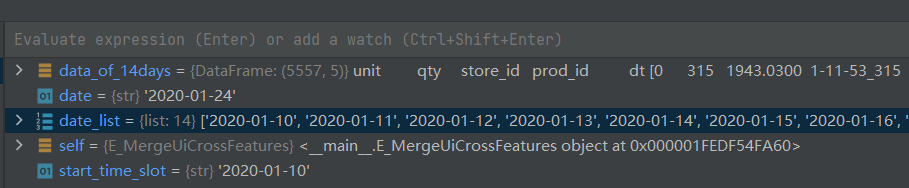